# **Описание модели**
1. Эта модель достигла наилучших результатов работы - ошибка 42%
2. В качестве входящих данных я использовал листs из дадасета: Износ, Обточки.

> Из данных листов были удалены все не коррелирующие столбцы: "Износ" ('Секция','Н_Ло','Н_Се','Н_серии','Н_КП','Номер'), "Обточки"('Номер','Толщина гребня на начало', 'Толщина
гребня на конец')

>Далее листы объединяются в один(объединение по столбцам)

>Удалены повторяющиеся столцы

>Избавляемся от дубликатов и нулевых значений, выброса

>Выделим данные с шагом измерения 0,25 и отдельно с шагом 0,1

> В листе "Обточки" оставленны только обточки с причиной 11 и 91 (Толщина гребня меньше нормы, Остроконечный накат гребня соотвтственно)

>В xTrein идут все данные кроме стобца "Износ"

>В yTrein идет столбец "Износ"

3. Сбока модели осуществлялась с помощью различных способов. Основоположниками архитектуры и гиперпараметров модели стал Keras Tuner, а далее ручная дороботка.

4. Добавил возможность дообучения.



##Старт

In [ ]:
#Импорт библиотек
!pip install sweetviz

import gc

import sweetviz as sv

import pandas as pd

import numpy as np

import tensorflow as tf

import pandas as pd

from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, MaxPooling1D

from tensorflow.keras import utils

from tensorflow.keras.optimizers import Adam, Adadelta, Adagrad, RMSprop

from tensorflow.keras.preprocessing.text import Tokenizer

from keras.callbacks import  ReduceLROnPlateau,  EarlyStopping , ModelCheckpoint

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 32.6 MB/s eta 0:00:00


In [ ]:
#Загружаем датасет(листы) в разыне переменные
#data_total = pd.read_excel('/content/drive/MyDrive/Учеба УИИ/Project Train/222 253 640.xlsx',sheet_name='TOTAL')
#data_total_q = pd.read_excel('/content/drive/MyDrive/Учеба УИИ/Project Train/222 253 640.xlsx', sheet_name='TOTAL_Q')
data_wear = pd.read_excel('/content/drive/MyDrive/Учеба УИИ/Project Train/222 253 640.xlsx', sheet_name='Износ')
data_turning = pd.read_excel('/content/drive/MyDrive/Учеба УИИ/Project Train/222 253 640.xlsx', sheet_name='Обточки')

##Визуализация

In [ ]:
# Визуальная оценка ошибки на обучающей и проверочной выборках

def compare_sharp_loss (history, x_size, y_size):
  plt.figure(figsize=(x_size,y_size))
  plt.plot(history.history['loss'],
         label='Ошибка на обучающей выборке')
  plt.plot(history.history['val_loss'],
         label='Ошибка проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Средняя ошибка')
  plt.legend()
  plt.show()

In [ ]:
def check_MAE_predictl_Input (model,
                                    x_data,
                                    y_data,
                                    plot=False):

  x_pred =model.predict(x_data)
  x_pred = y_scaler.inverse_transform(x_pred.reshape(-1,1)).flatten()
  mae = mean_absolute_error(y_data,x_pred)
#  for n in range (0,len(x_data)):
#      print(f'Верное значение {y_data[n]} - предсказанное {x_pred[n]} в {n} =', abs(y_data[n] - x_pred[n]))
  print('Среднаяя абслолютная ошибка = ',mae)
  print('Среднаий процент ощибки = ', mae/y_data.mean()*100, '%')

  plt.scatter(y_data, x_pred)
  plt.xlabel('Правильные значение')
  plt.ylabel('Предсказания')
  plt.axis('equal')
  plt.xlim(plt.xlim())
  plt.ylim(plt.ylim())
  plt.plot([0, 250], [0, 250])
  plt.show()



##Колбэк

In [ ]:
# Колбэки
my_callbacks = [
    EarlyStopping(monitor='val_loss',
                        min_delta=0,
                        patience=10,
                        verbose=1,
                        baseline=None,
                        restore_best_weights=True),
    ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5',
                              monitor='val_loss',
                              verbose=1,
                              save_best_only=True,
                              mode='min',
                              baseline=None,
                              initial_value_threshold=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=2, verbose=1)
]


## Работа с данными

In [ ]:
#Удаляем все не корелирующие данные
data_turning = data_turning.drop(columns=['Секция','Н_Ло','Н_Се','Н_серии','Н_КП','Номер'], errors='ignore')
data_wear = data_wear.drop(columns=['Номер','Толщина гребня на начало', 'Толщина гребня на конец'], errors='ignore')

In [ ]:
#Смотрим размеры данных
print(data_turning.shape)
print(data_wear.shape)

(61292, 10)
(84114, 12)


In [ ]:
#Соединяем листы
data_all = pd.concat([data_wear,data_turning], axis=1)

#Удаляем лишние данные
data_all = data_all.drop(columns= ['Причина','Вид причины','Unnamed: 0','Дирекция','Квартал','Год','Дата обточки','Начало','Конец','ТТ',
                                    'Н_ЦО', 'Н_Ди'], errors='ignore')
#Зменяем все столбцы с NaN на ноль
data_all = data_all.fillna(0)
data_all.columns

Index(['Н_Ло', 'Н_КП', 'Н_Се', 'Секция', 'Н_серии', 'Период', 'Износ',
       'Пробег за период', 'Пробег на начало', 'Пробег на конец', 'Н_ВП',
       'Н_Пр', 'Номер места'],
      dtype='object')

In [ ]:
#Избавляемся от дубликатов и нулевых значений, выброса
data_all.drop_duplicates()
data_all = data_all.loc[~data_all['Пробег за период'].isin([0])]
data_all = data_all.loc[~data_all['Износ'].isin([0])]
data_all = data_all[data_all.Износ < 30]

In [ ]:
#Выделим данные с шагом измерения 0,25
data_all_scale = data_all[data_all.Износ % 0.25 == 0].reset_index(drop=True)

In [ ]:
data_all_scale

,Н_Ло,Н_КП,Н_Се,Секция,Н_серии,Период,Износ,Пробег за период,Пробег на начало,Пробег на конец,Н_ВП,Н_Пр,Номер места
0,4573,81329,18728,1,253,317,3.00,133132.0,1873288.0,2006420.0,9.0,97.0,4.0
1,4573,114993,18728,1,253,317,3.00,133132.0,1873288.0,2006420.0,2.0,22.0,5.0
2,4573,82697,18728,1,253,156,2.00,66650.0,1939770.0,2006420.0,9.0,92.0,6.0
3,4573,117134,18728,1,253,160,0.50,66482.0,1873288.0,1939770.0,9.0,92.0,1.0
4,4573,117134,18728,1,253,156,3.50,66650.0,1939770.0,2006420.0,2.0,21.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66882,1864,32827,11522,2,222,82,1.00,40319.0,650685.0,691004.0,0.0,0.0,0.0
66883,1864,18266,11522,2,222,80,0.50,40657.0,610028.0,650685.0,0.0,0.0,0.0
66884,1864,18266,11522,2,222,82,1.00,40319.0,650685.0,691004.0,0.0,0.0,0.0
66885,1864,18274,11522,2,222,80,1.25,40657.0,610028.0,650685.0,0.0,0.0,0.0


In [ ]:
#Копируем первоначальный дата сет для защиты от изменений или работы в других частях кода
data_all_1 = data_all_scale.copy()


In [ ]:
#Сохраняием данные в Exel для визуального изучения результата
data_all_1.to_excel("output.xlsx")

In [ ]:
#Оставляем только прицины износа: остроканечный накат гребня и толщина гребня меньше нормы
#Остальные причины износа могут резко и непредсказуемо повлиять на износ колеса
data_all_1 = data_all_1[(data_all_1['Н_Пр'] == 11) | (data_all_1['Н_Пр'] == 91)].reset_index(drop=True)

In [ ]:
data_all_1

,Н_Ло,Н_КП,Н_Се,Секция,Н_серии,Период,Износ,Пробег за период,Пробег на начало,Пробег на конец,Н_ВП,Н_Пр,Номер места
0,4573,117376,23439,2,253,289,1.50,120438.0,1873288.0,1993726.0,1.0,11.0,2.0
1,4573,81104,23439,2,253,289,1.75,120438.0,1873288.0,1993726.0,1.0,11.0,5.0
2,4573,135861,18729,3,253,161,1.25,66482.0,1873288.0,1939770.0,1.0,11.0,2.0
3,4574,135113,17299,2,253,332,2.50,155603.0,1954550.0,2110153.0,1.0,11.0,5.0
4,4574,136035,17299,2,253,332,2.75,155603.0,1954550.0,2110153.0,9.0,91.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28421,2086,119257,17163,1,222,238,1.75,135517.0,244691.0,380208.0,1.0,11.0,4.0
28422,2086,85597,17163,1,222,238,1.50,135517.0,244691.0,380208.0,1.0,11.0,3.0
28423,2086,33584,17163,1,222,180,2.00,108818.0,271390.0,380208.0,1.0,11.0,2.0
28424,2086,33584,17163,1,222,97,0.25,54107.0,380349.0,434456.0,9.0,91.0,4.0


                                             |          | [  0%]   00:00 -> (? left)


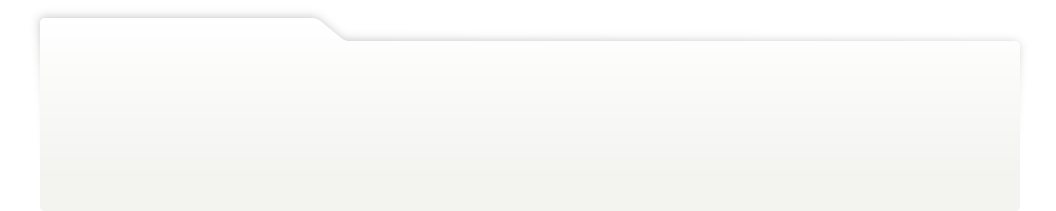
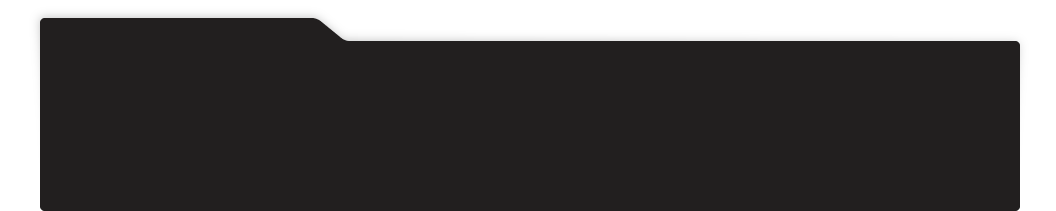
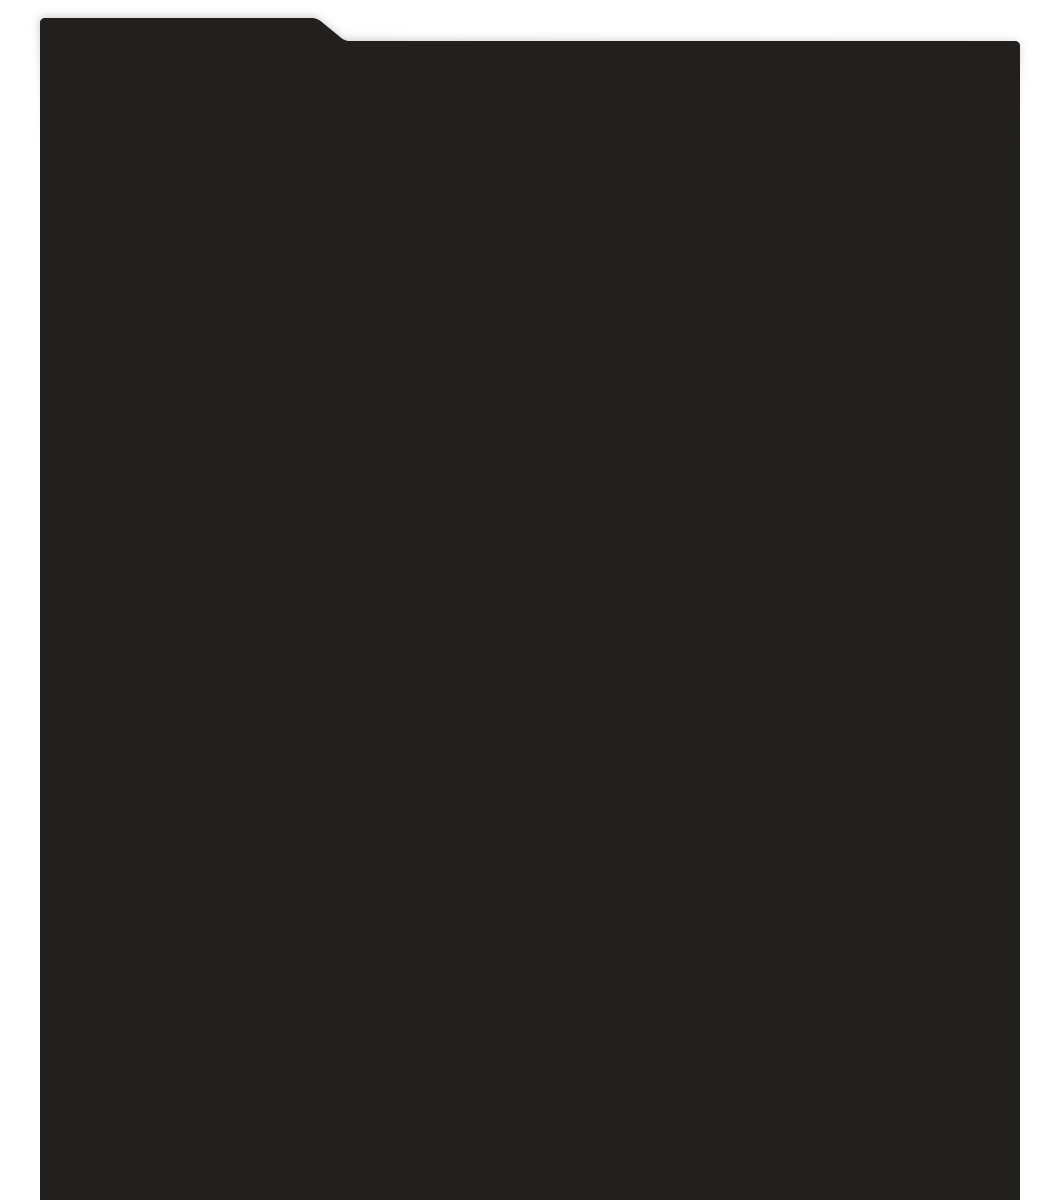
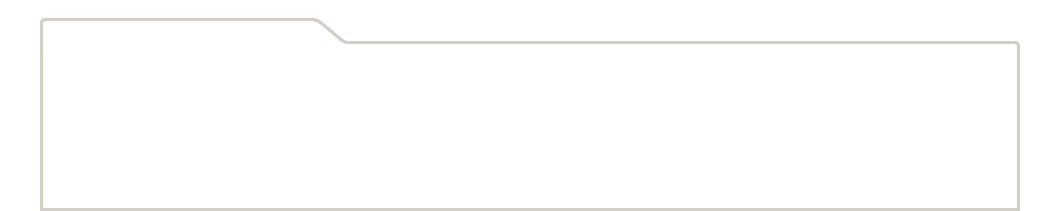
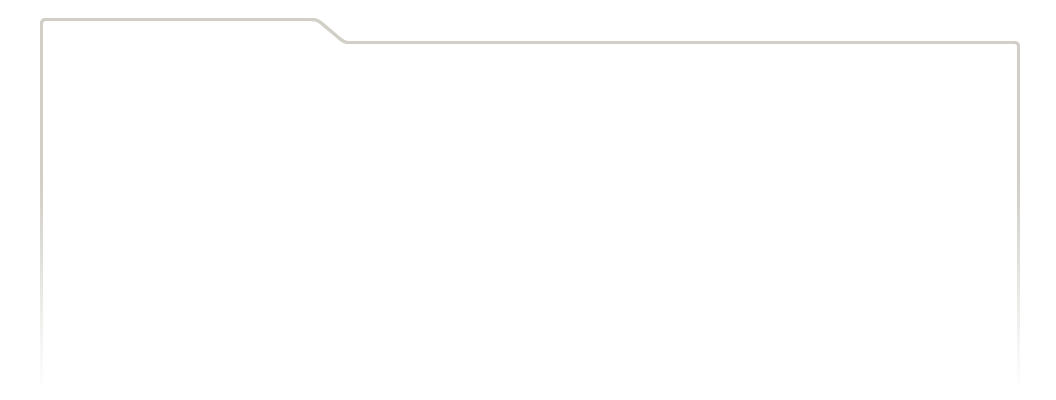
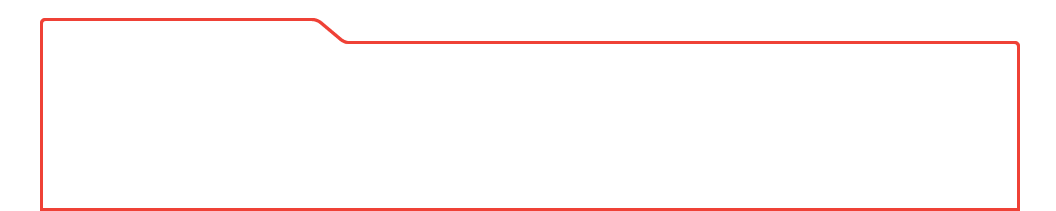
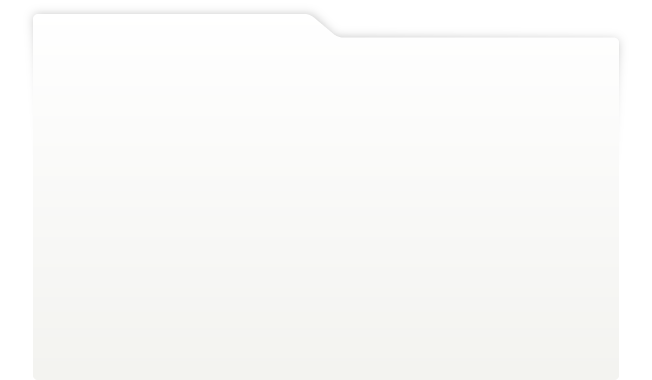
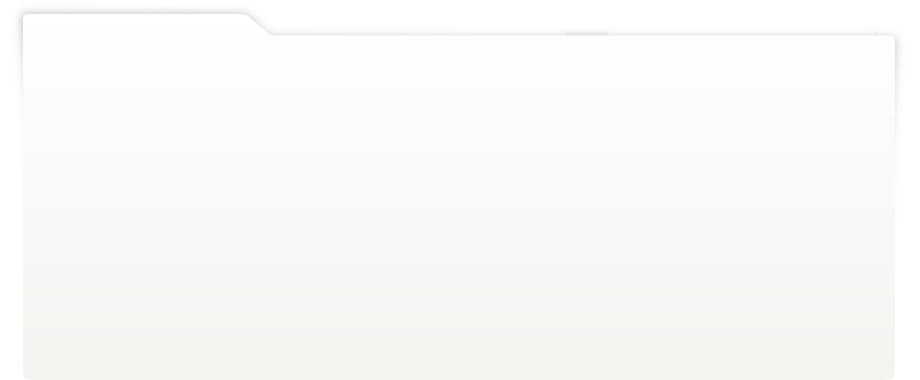
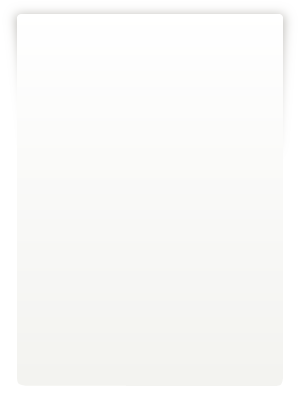
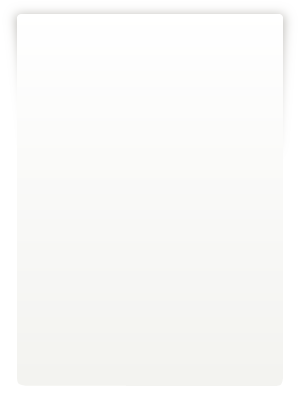
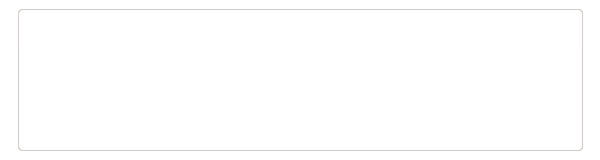
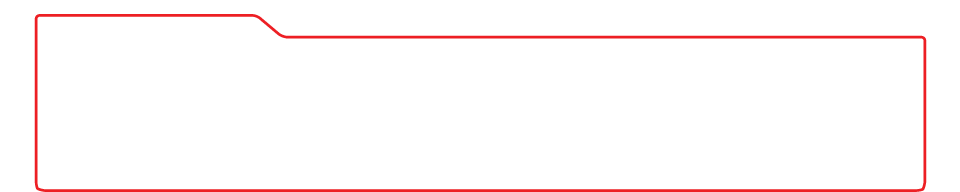
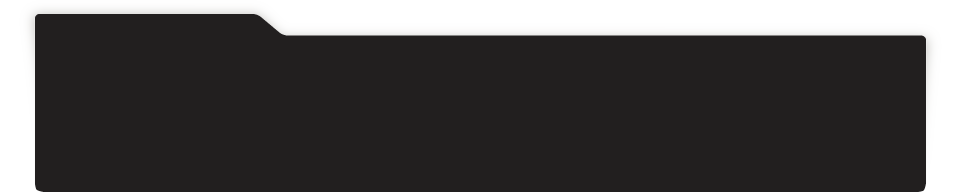
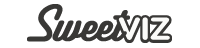
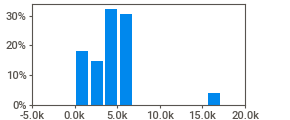
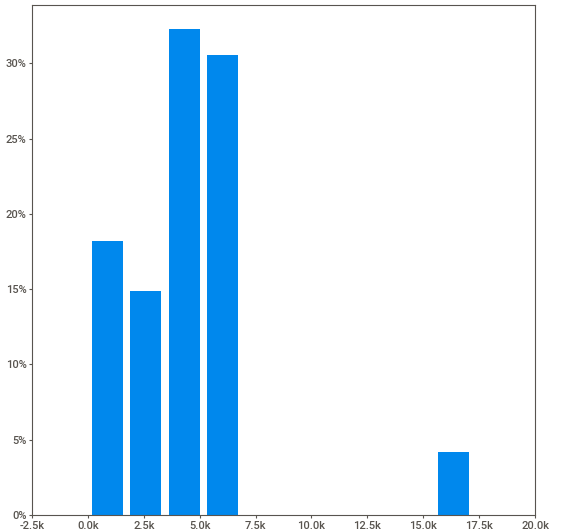
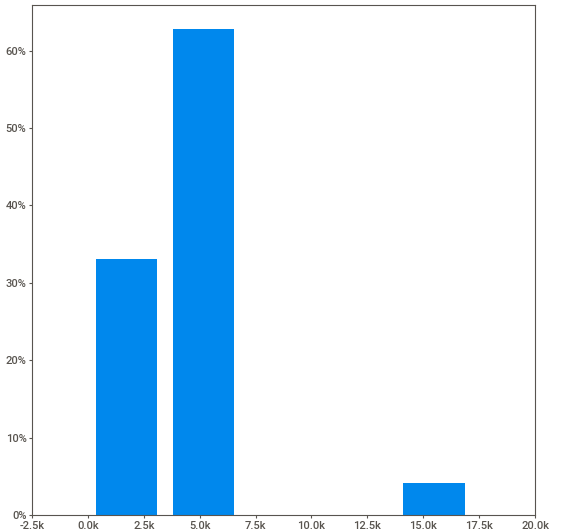
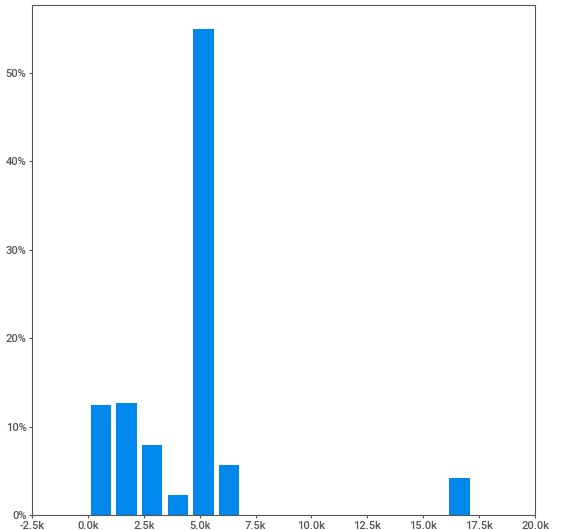
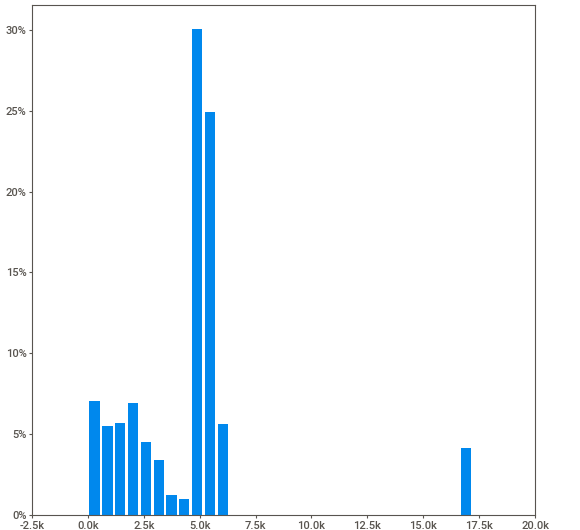
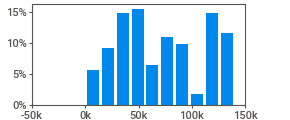
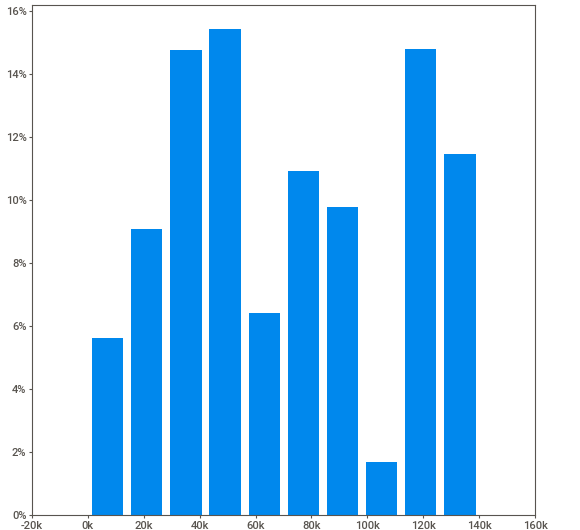
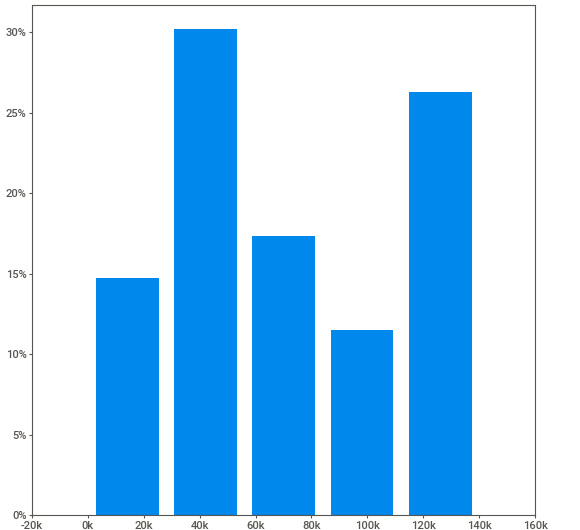
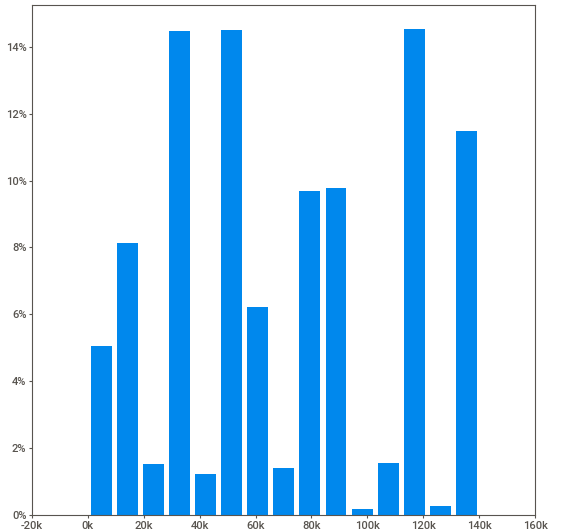
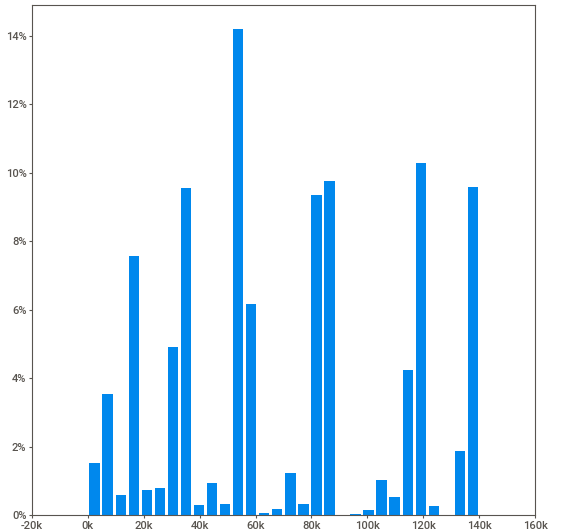
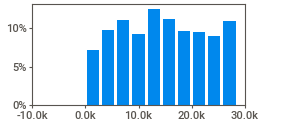
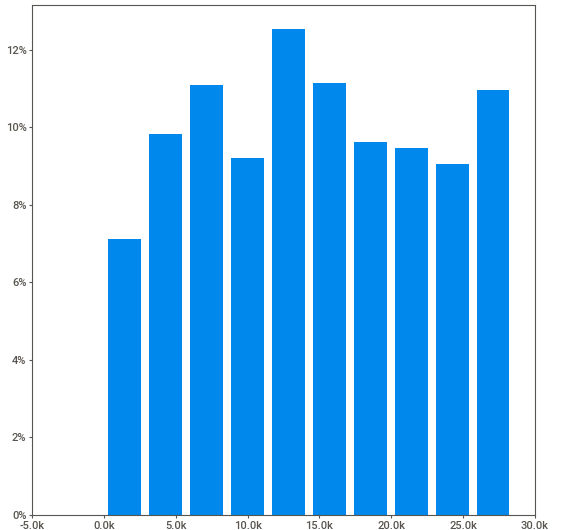
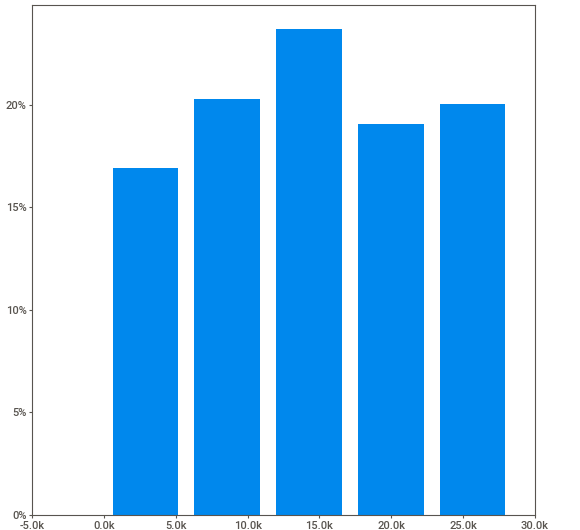
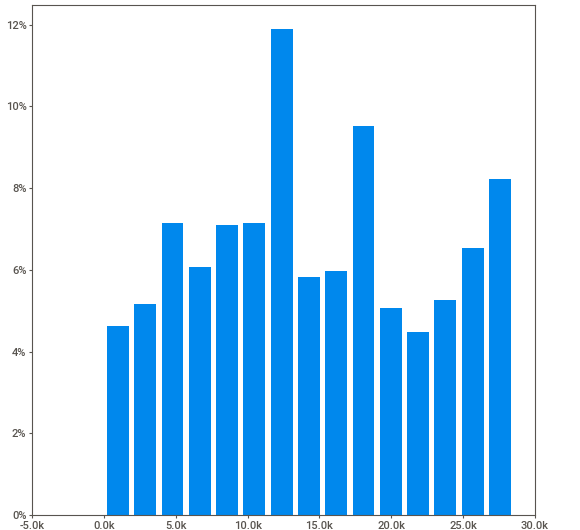
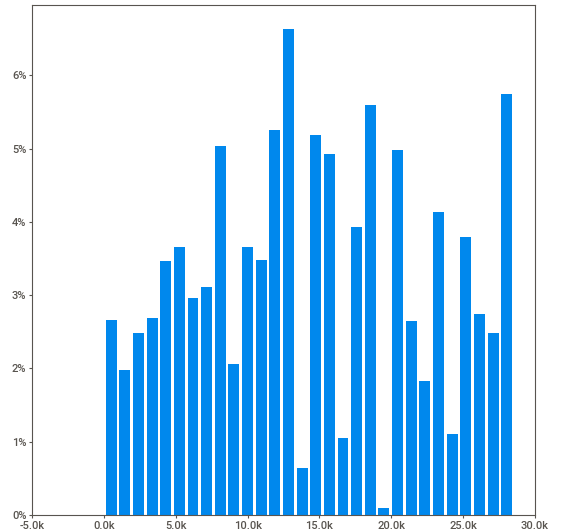
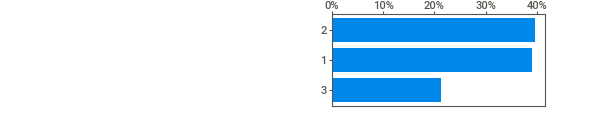
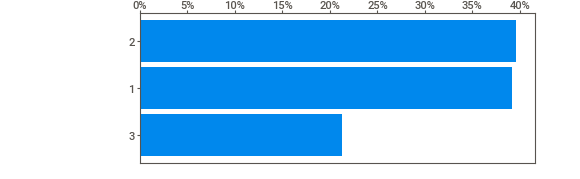
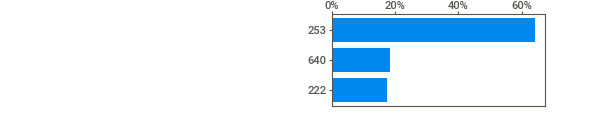
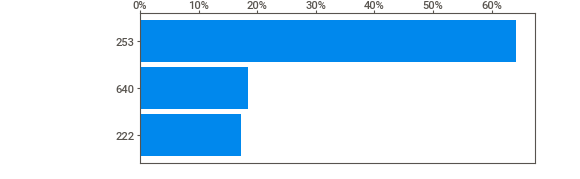
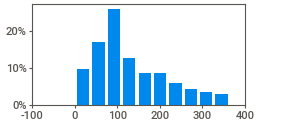
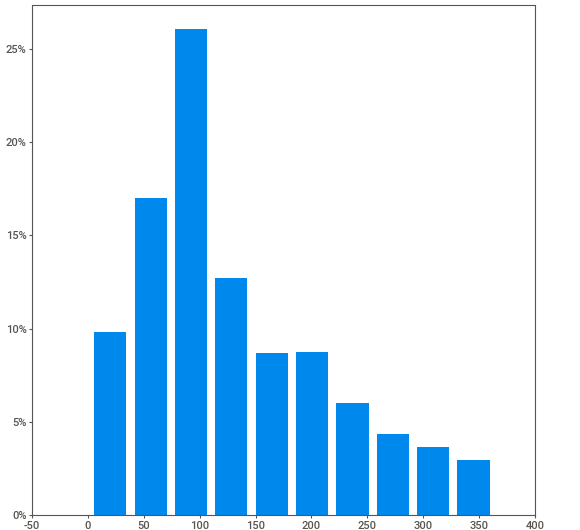
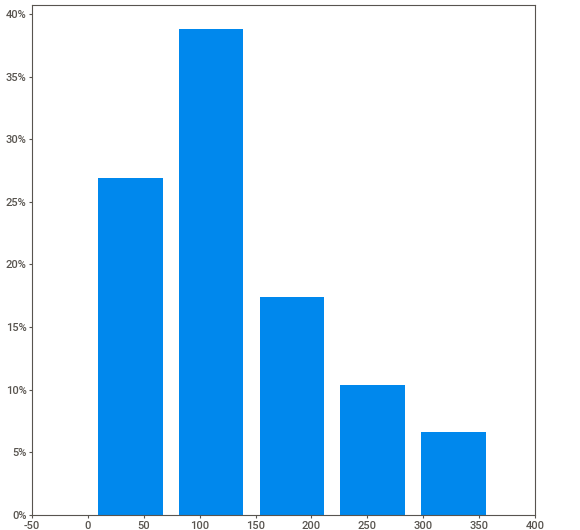
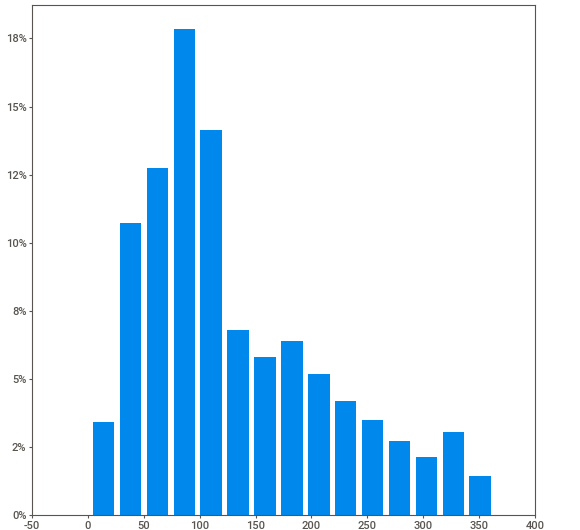
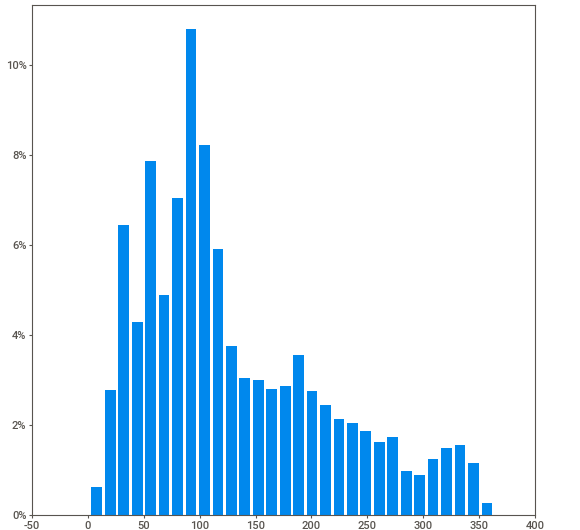
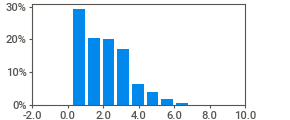
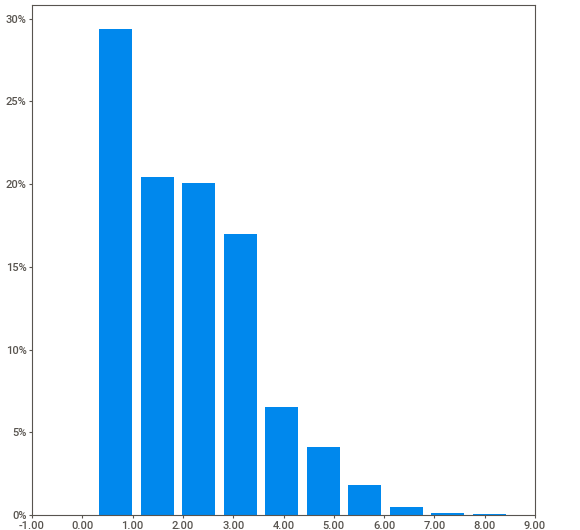
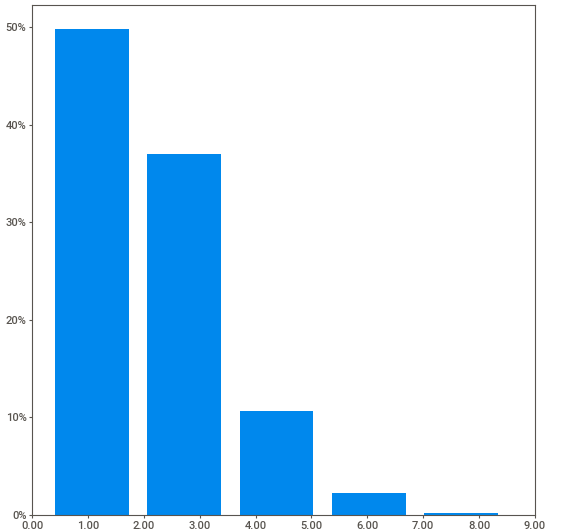
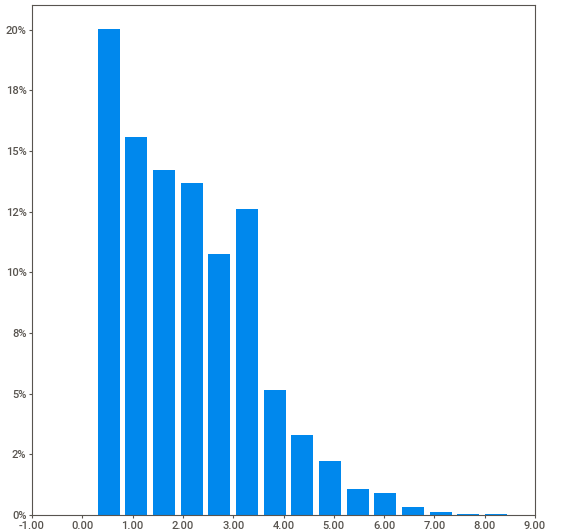
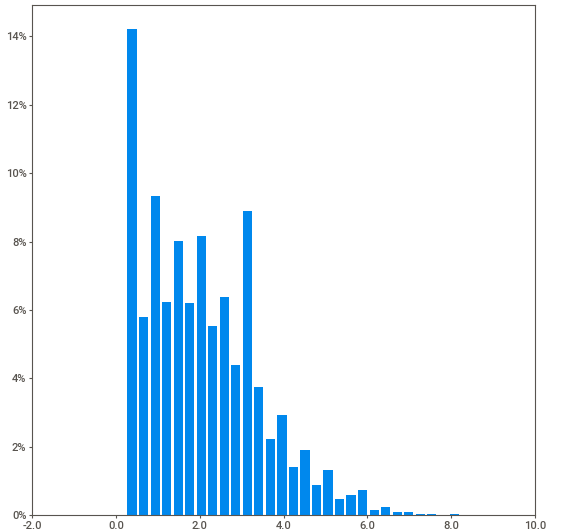
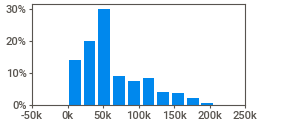
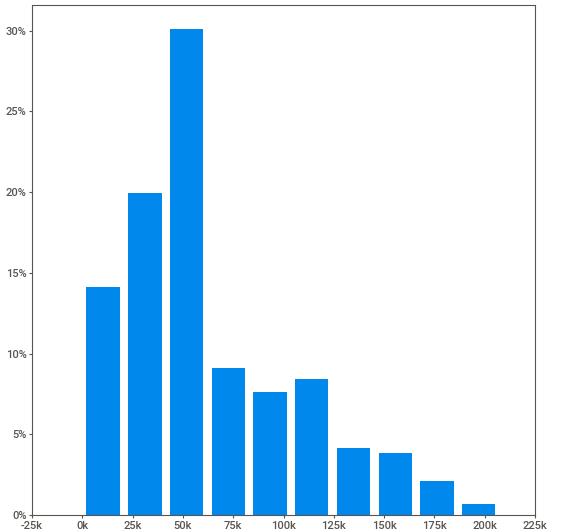
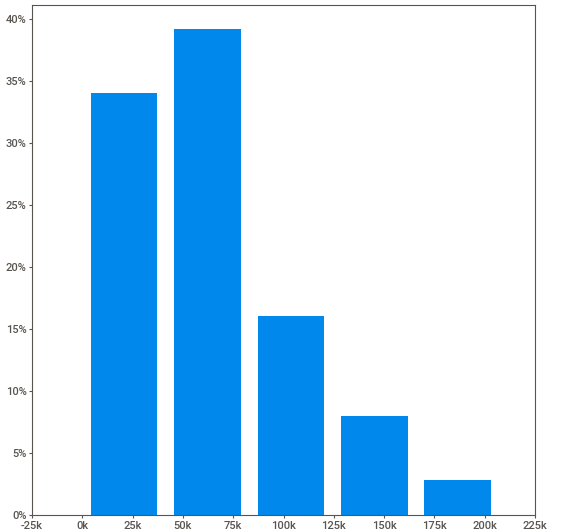
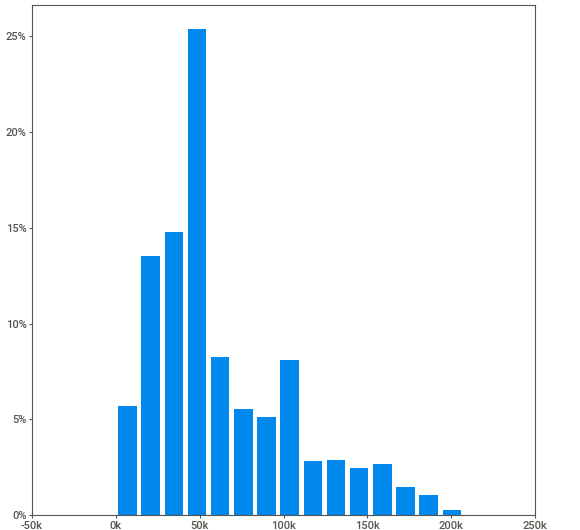
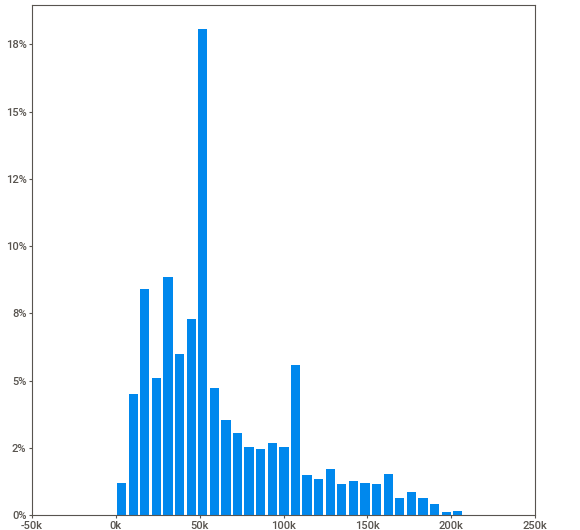
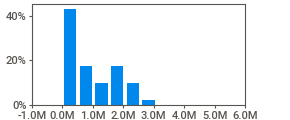
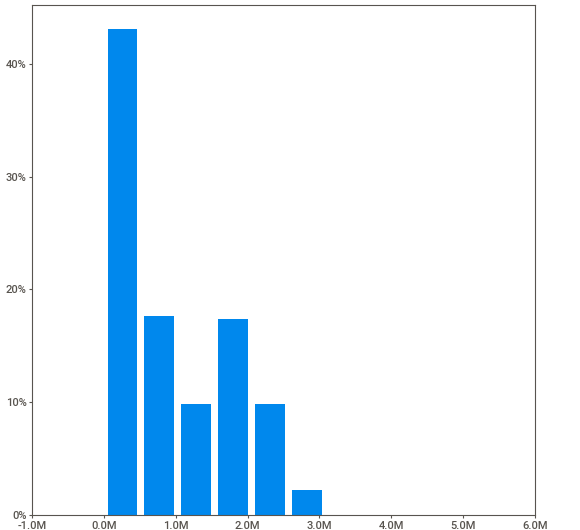
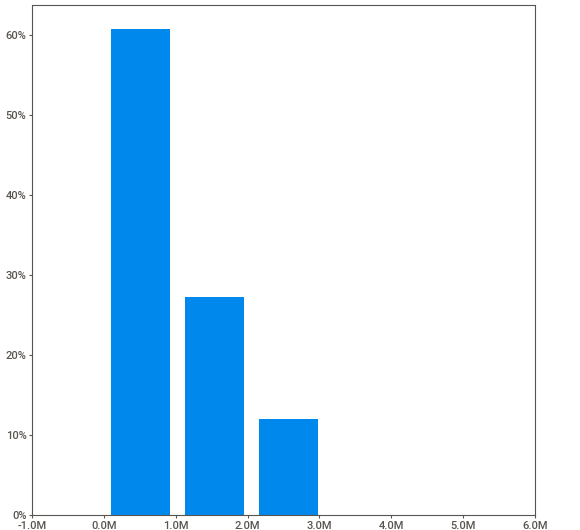
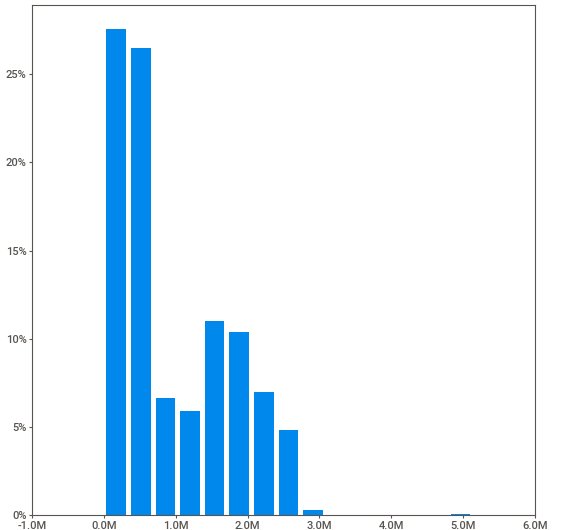
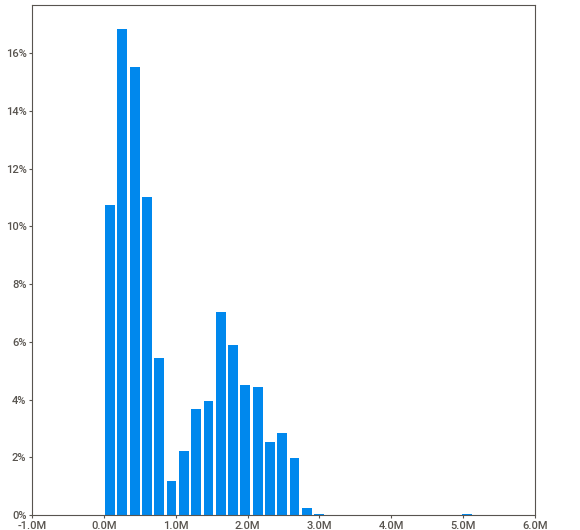
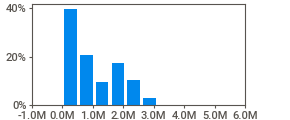
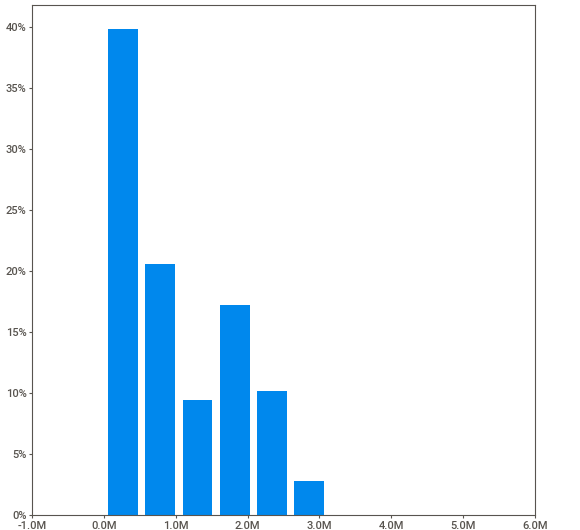
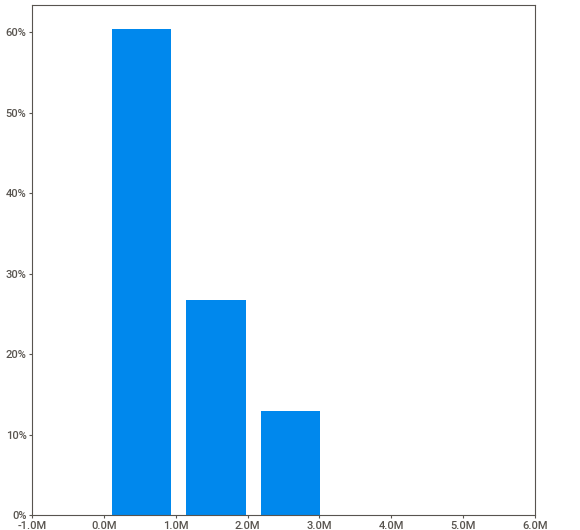
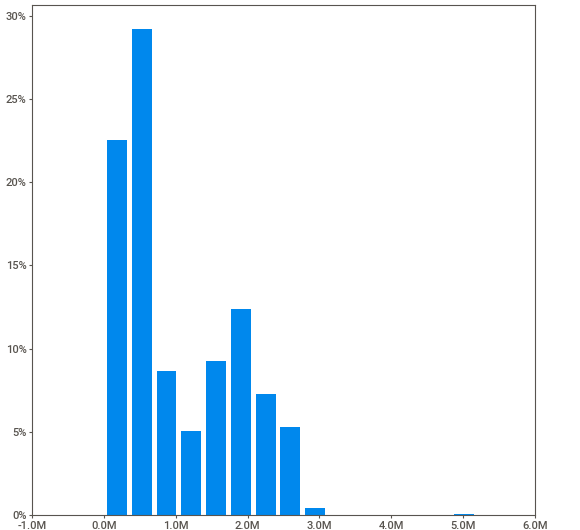
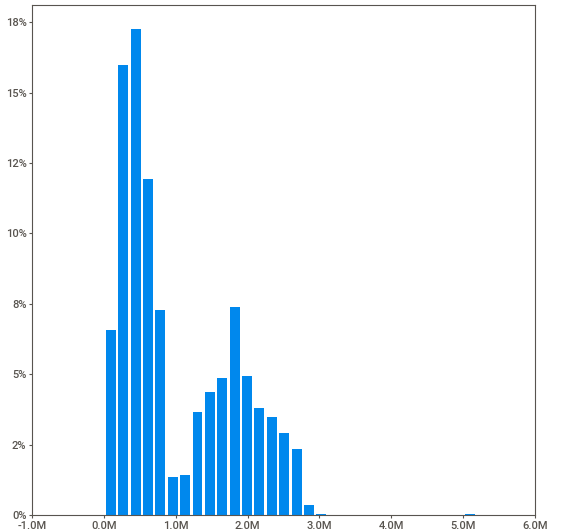
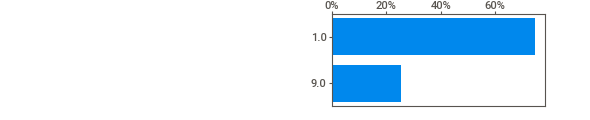
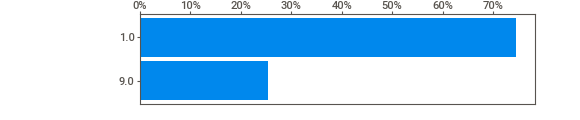
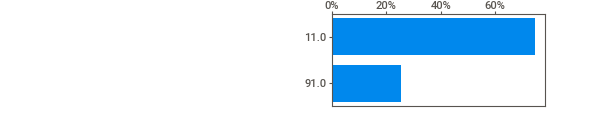
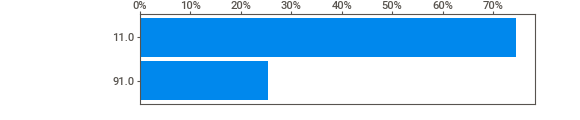
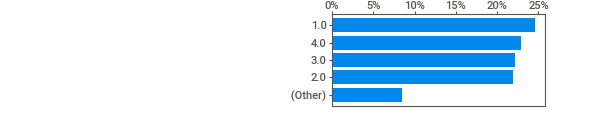
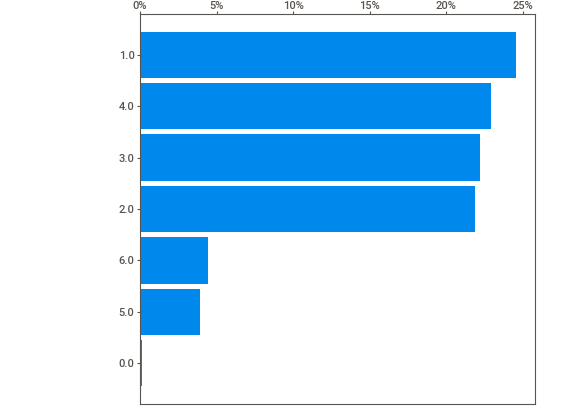
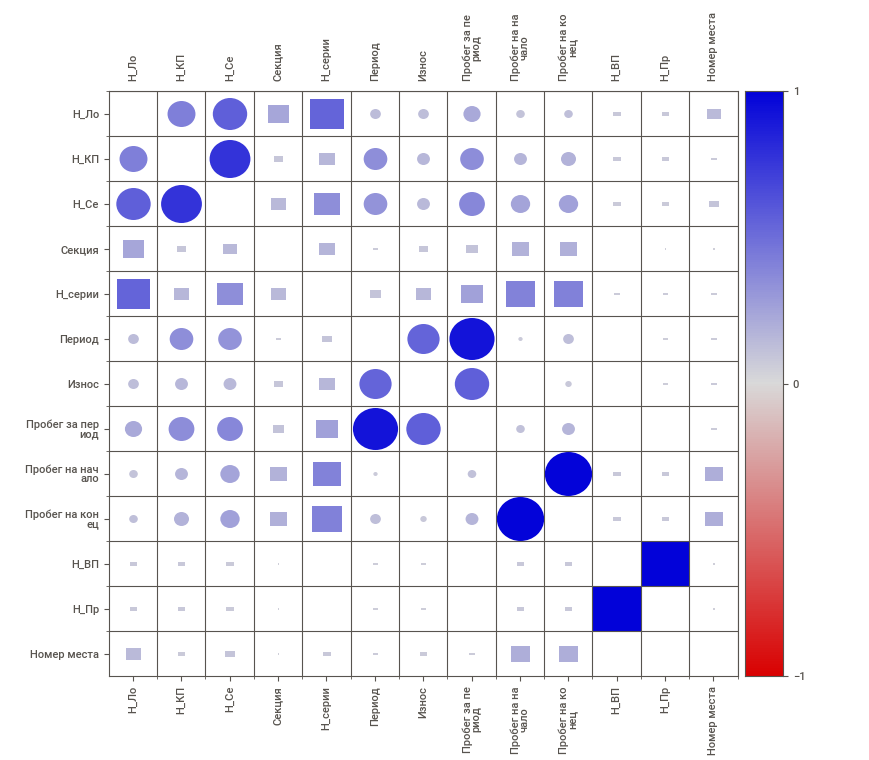
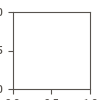

In [ ]:
#Смотрим кореляцию остаточных данных
my_report_1 = sv.analyze(data_all_1)
my_report_1.show_notebook()

In [ ]:
#Удаляем 'износ' из обучающих данных
data_all_1_xTrain = data_all_1.drop(columns='Износ')
print('Столбцы в общем датасете:', data_all_1.columns)
print('Столбцы в обучающем датасете:',data_all_1_xTrain.columns)

Столбцы в общем датасете: Index(['Н_Ло', 'Н_КП', 'Н_Се', 'Секция', 'Н_серии', 'Период', 'Износ',
       'Пробег за период', 'Пробег на начало', 'Пробег на конец', 'Н_ВП',
       'Н_Пр', 'Номер места'],
      dtype='object')
Столбцы в обучающем датасете: Index(['Н_Ло', 'Н_КП', 'Н_Се', 'Секция', 'Н_серии', 'Период',
       'Пробег за период', 'Пробег на начало', 'Пробег на конец', 'Н_ВП',
       'Н_Пр', 'Номер места'],
      dtype='object')


In [ ]:
#Создаем трейны
xTrain_1 = np.array(data_all_1_xTrain)
yTrain_1 = np.array(data_all_1['Износ'])
print(xTrain_1.shape)
print(yTrain_1.shape)


(28426, 12)
(28426,)


In [ ]:
#Деление на выборки(делим раньше чем нормализуем для избежания пересечения данных)
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(xTrain_1,yTrain_1,test_size=0.2,shuffle = False)
print(x_train_1.shape)
print(y_train_1.shape)
print(x_test_1.shape)
print(y_test_1.shape)


(22740, 12)
(22740,)
(5686, 12)
(5686,)


In [ ]:
print(y_test_1)

[1.   4.75 2.25 ... 2.   0.25 2.25]


In [ ]:
#Нормализуем данные
#x_scaler = StandardScaler()
x_scaler = MinMaxScaler()
x_train_scaled_1 = x_scaler.fit_transform(x_train_1)
print('Размер нормализованной обучающей выборки', x_train_scaled_1.shape)

x_test_scaled_1 = x_scaler.fit_transform(x_test_1)
print('Размер нормализованной тестовой выборки', x_test_scaled_1.shape)

y_train_scaled_1 = y_train_1.reshape(-1,1)
y_scaler = MinMaxScaler()
#y_scaler = StandardScaler()
y_train_scaled_1 = y_scaler.fit_transform(y_train_scaled_1)
print('Размер нормализованных правельных ответов', y_train_scaled_1.shape)

Размер нормализованной обучающей выборки (22740, 12)
Размер нормализованной тестовой выборки (5686, 12)
Размер нормализованных правельных ответов (22740, 1)


###НС

In [ ]:
#Сама нейронка LeakyReLU, ELU
model_1 = Sequential([

    Dense(650, activation='LeakyReLU'),
#    BatchNormalization(),
    Dropout(0.3),
    Dense(2000, activation='LeakyReLU'),
#    BatchNormalization(),
    Dropout(0.3),
    Dense(5000, activation='LeakyReLU'),
#    BatchNormalization(),
    Dropout(0.3),
    Dense(650, activation='LeakyReLU'),
#    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='linear'),
    ])

In [ ]:
model_1.compile(optimizer=Adam(learning_rate=0.0001), loss='mae', metrics=['mae'])
history = model_1.fit(x_train_scaled_1, y_train_scaled_1, epochs=100,batch_size=50, validation_split=0.2, shuffle=True, verbose=1, callbacks=my_callbacks)
compare_sharp_loss(history,10,4)



In [ ]:
check_MAE_predictl_Input(model_1, x_train_scaled_1,y_test_1, True)

Epoch 1/100
360/364 [============================>.] - ETA: 0s - loss: 0.1072 - mae: 0.1072
Epoch 1: val_loss did not improve from 0.09928
364/364 [==============================] - 5s 9ms/step - loss: 0.1071 - mae: 0.1071 - val_loss: 0.1006 - val_mae: 0.1006 - lr: 1.0000e-05
Epoch 2/100
364/364 [==============================] - ETA: 0s - loss: 0.1069 - mae: 0.1069
Epoch 2: val_loss did not improve from 0.09928
364/364 [==============================] - 3s 8ms/step - loss: 0.1069 - mae: 0.1069 - val_loss: 0.1012 - val_mae: 0.1012 - lr: 1.0000e-05
Epoch 3/100
360/364 [============================>.] - ETA: 0s - loss: 0.1068 - mae: 0.1068
Epoch 3: val_loss did not improve from 0.09928

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.
364/364 [==============================] - 3s 8ms/step - loss: 0.1068 - mae: 0.1068 - val_loss: 0.1009 - val_mae: 0.1009 - lr: 1.0000e-05
Epoch 4/100
360/364 [============================>.] - ETA: 0s - loss: 0.1072 - mae: 0.1072


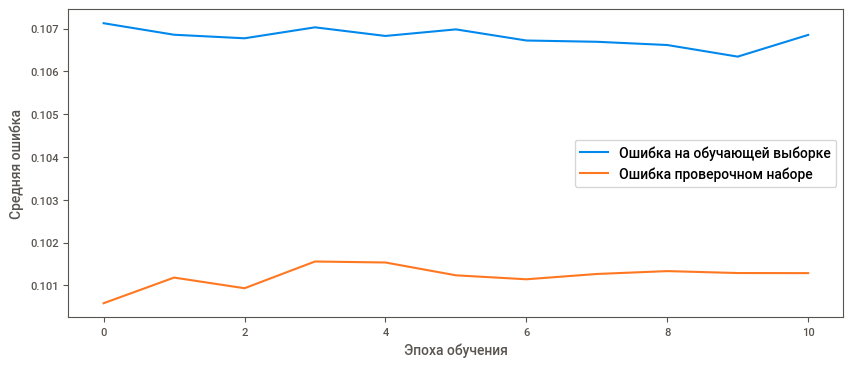

178/178 [==============================] - 0s 2ms/step
Среднаяя абслолютная ошибка =  0.8002429850585562
Среднаий процент ощибки =  43.24651060250868 %


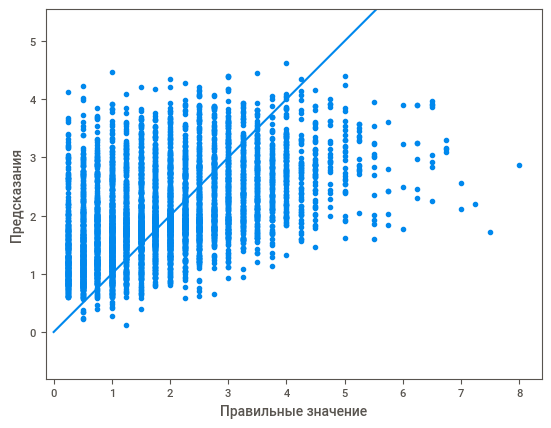

In [ ]:
#Дообучение модели

model_1.compile(optimizer=Adam(learning_rate=0.00001), loss='mae', metrics=['mae'])
history = model_1.fit(x_train_scaled_1, y_train_scaled_1, epochs=100,batch_size=50, validation_split=0.2, shuffle=True, verbose=1, callbacks=my_callbacks)
compare_sharp_loss(history,10,4)

check_MAE_predictl_Input(model_1, x_test_scaled_1,y_test_1, True)

Epoch 1/100
362/364 [============================>.] - ETA: 0s - loss: 0.1076 - mae: 0.1076
Epoch 1: val_loss did not improve from 0.09928
364/364 [==============================] - 5s 9ms/step - loss: 0.1075 - mae: 0.1075 - val_loss: 0.1006 - val_mae: 0.1006 - lr: 1.0000e-06
Epoch 2/100
363/364 [============================>.] - ETA: 0s - loss: 0.1076 - mae: 0.1076
Epoch 2: val_loss did not improve from 0.09928
364/364 [==============================] - 3s 8ms/step - loss: 0.1076 - mae: 0.1076 - val_loss: 0.1007 - val_mae: 0.1007 - lr: 1.0000e-06
Epoch 3/100
359/364 [============================>.] - ETA: 0s - loss: 0.1075 - mae: 0.1075
Epoch 3: val_loss did not improve from 0.09928

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.
364/364 [==============================] - 3s 8ms/step - loss: 0.1071 - mae: 0.1071 - val_loss: 0.1008 - val_mae: 0.1008 - lr: 1.0000e-06
Epoch 4/100
360/364 [============================>.] - ETA: 0s - loss: 0.1076 - mae: 0.1076


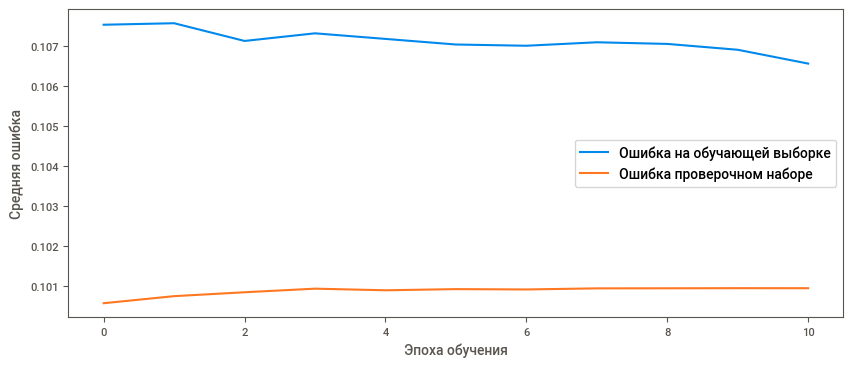

178/178 [==============================] - 0s 2ms/step
Среднаяя абслолютная ошибка =  0.7986350266834196
Среднаий процент ощибки =  43.15961375965331 %


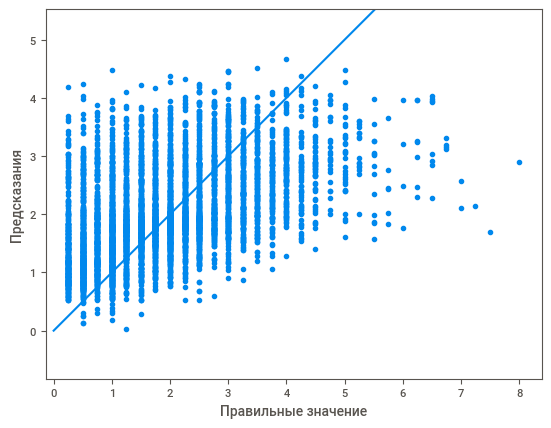

In [ ]:
#Дообучение модели

model_1.compile(optimizer=Adam(learning_rate=0.000001), loss='mae', metrics=['mae'])
history = model_1.fit(x_train_scaled_1, y_train_scaled_1, epochs=100,batch_size=50, validation_split=0.2, shuffle=False, verbose=1, callbacks=my_callbacks)
compare_sharp_loss(history,10,4)

check_MAE_predictl_Input(model_1, x_test_scaled_1,y_test_1, True)

**Вывод**: Продолжаем работу =)